# Phase 1: Anomaly video heatmap Decoder

## Update Anomaly_maps_decoder

In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from anomaly_qwen2_5_vl import Anomaly_Qwen2_5_VLForConditionalGeneration, Qwen2_5_VLProcessor
from qwen_vl_utils import process_vision_info

best_ckpt_path = 'ckpts/step006800.pth'
print(f"Loading best checkpoint: {best_ckpt_path}")

base = Anomaly_Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Geo/Anomaly_Qwen2.5-VL-7B-Instruct",
    torch_dtype="auto",
    device_map="auto",
)
processor = Qwen2_5_VLProcessor.from_pretrained("Geo/Anomaly_Qwen2.5-VL-7B-Instruct")
print(base.model.anomaly_maps_decoder)

state_dict = torch.load(best_ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = base.model.anomaly_maps_decoder.load_state_dict(state_dict, strict=False)
print("[Info] missing:", missing, '|', "[Info] unexpected:", unexpected)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Normal batch: {'input_ids': torch.Size([1680, 21]), 'attention_mask': torch.Size([1680, 21])} 
Abnormal batch: {'input_ids': torch.Size([1680, 21]), 'attention_mask': torch.Size([1680, 21])}
Loading best checkpoint: ckpts/step006800.pth


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at Geo/Anomaly_Qwen2.5-VL-7B-Instruct were not used when initializing Anomaly_Qwen2_5_VLForConditionalGeneration: ['model.language_model.anomaly_maps_decoder.fuse_weights', 'model.language_model.anomaly_maps_decoder.mlps.0.model.0.bias', 'model.language_model.anomaly_maps_decoder.mlps.0.model.0.weight', 'model.language_model.anomaly_maps_decoder.mlps.0.model.2.bias', 'model.language_model.anomaly_maps_decoder.mlps.0.model.2.weight', 'model.language_model.anomaly_maps_decoder.mlps.1.model.0.bias', 'model.language_model.anomaly_maps_decoder.mlps.1.model.0.weight', 'model.language_model.anomaly_maps_decoder.mlps.1.model.2.bias', 'model.language_model.anomaly_maps_decoder.mlps.1.model.2.weight', 'model.language_model.anomaly_maps_decoder.mlps.2.model.0.bias', 'model.language_model.anomaly_maps_decoder.mlps.2.model.0.weight', 'model.language_model.anomaly_maps_decoder.mlps.2.model.2.bias', 'model.language_model.anomaly_maps_decoder.mlps.2.model.2.weight'

AnomalyHeatmap(
  (mlps): ModuleList(
    (0-4): 5 x MLP(
      (model): Sequential(
        (0): Linear(in_features=1280, out_features=1024, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=1024, out_features=3584, bias=True)
      )
    )
  )
)
[Info] missing: [] | [Info] unexpected: []


## Demo

In [2]:
# Messages containing a local video path and a text query
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "video",
                "video": "./dataset/train/01_0136-336_359.mp4",  # truck
                # "video": "./dataset/train/01_0028-288_311.mp4",  # running
                # "video": "./dataset/train/04_0001-408_431.mp4",  # jumping
                # "video": "./dataset/train/07_0048-180_203.mp4",  # fighting
                "fps": 24.0,  # Visual encoder sampling frame rate (FPS)
            },
            {
                "type": "text",
                "text": "Is there any anomaly in the video？"
                # "text": "Videoda herhangi bir anormallik var mı?"
                # "text": "视频里有什么异常吗？"
            },
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs, video_kwargs = process_vision_info(messages, return_video_kwargs=True)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
    **video_kwargs,
)
inputs = inputs.to("cuda")

# Inference
generated_ids = base.generate(**inputs, max_new_tokens=512)
anomaly_maps = base.model.anomaly_maps
anomaly_prompt = base.model.anomaly_prompt_embeds
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)


qwen-vl-utils using decord to read video.


In [3]:
print(text)
print(base.model.video_embeds.shape)
print(anomaly_prompt.shape)  # (T*10, dim_out)
print(base.model.inputs_embeds.shape)


<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|video_pad|><|vision_end|><|anomaly_prompt_start|><|anomaly_prompt_pad|><|anomaly_prompt_end|>Is there any anomaly in the video？<|im_end|>
<|im_start|>assistant

torch.Size([6324, 3584])
torch.Size([120, 3584])
torch.Size([1, 6475, 3584])


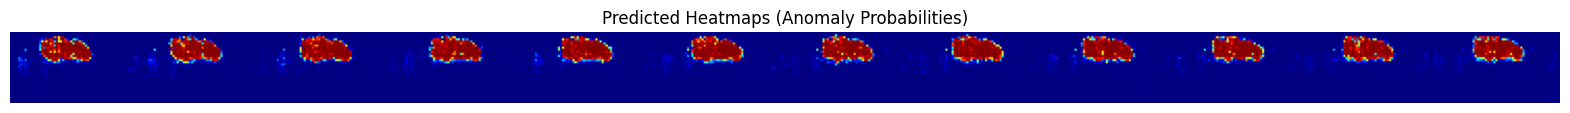

[System]>>>No, there doesn't appear to be an obvious anomaly in the video. The scene depicts a typical urban or suburban setting with people walking and a small truck driving on a paved area. The individuals seem to be going about their daily activities without any unusual behavior. The truck is moving slowly, and the pedestrians are walking at a normal pace. There are no signs of distress, urgency, or anything out of the ordinary in the actions of the people or the environment.


In [4]:
# Get the number of frames
# 获取帧数
T = anomaly_maps.shape[0]

vis_preds = []

# Get the anomaly probability maps after softmax (use class 1, which represents anomaly)
# 获取softmax后的异常概率图（取类别1表示异常的概率）
prob_maps = torch.softmax(anomaly_maps.float(), dim=1)[:, 1].cpu().detach().numpy()  # (B, H, W)

for i in range(T):
    # Convert anomaly probability to [0,255] and uint8 for visualization
    # 将异常概率归一化到[0,255]并转换为uint8用于可视化
    heat = (prob_maps[i] * 255).astype(np.uint8)             # (H, W)

    # Apply color map (JET) to get RGB heatmap
    # 应用JET色彩映射，得到RGB热力图
    pred_color = cv2.applyColorMap(heat, cv2.COLORMAP_JET)   # (H, W, 3)
    vis_preds.append(pred_color)

# Concatenate all frames horizontally into one row
# 将所有帧横向拼接为一行
row_pred = cv2.hconcat(vis_preds)

# OpenCV uses BGR, convert to RGB for correct display
# OpenCV是BGR格式，需转换为RGB以正常显示
row_pred_rgb = cv2.cvtColor(row_pred, cv2.COLOR_BGR2RGB)

# Display with matplotlib
# 使用matplotlib进行显示
plt.figure(figsize=(20, 6))
plt.imshow(row_pred_rgb)
plt.axis('off')
plt.title("Predicted Heatmaps (Anomaly Probabilities)")
plt.show()

# Print the system output text
# 打印系统输出文本
print("[System]>>>" + output_text[0])


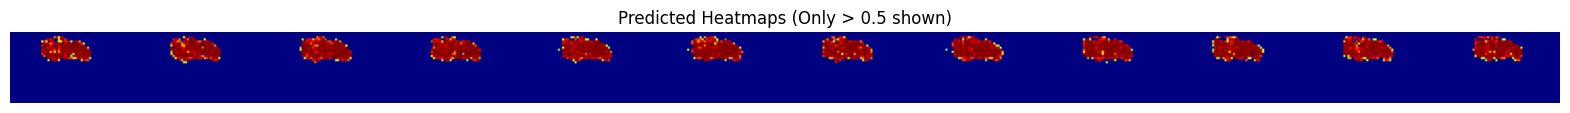

[System]>>>No, there doesn't appear to be an obvious anomaly in the video. The scene depicts a typical urban or suburban setting with people walking and a small truck driving on a paved area. The individuals seem to be going about their daily activities without any unusual behavior. The truck is moving slowly, and the pedestrians are walking at a normal pace. There are no signs of distress, urgency, or anything out of the ordinary in the actions of the people or the environment.


In [5]:
# Get the number of frames
# 获取帧数
T = anomaly_maps.shape[0]
vis_preds = []

# Get the anomaly probability map after softmax (take class 1 as anomaly probability)
# 获取softmax后的异常概率图（取类别1为异常概率）
prob_maps = torch.softmax(anomaly_maps.float(), dim=1)[:, 1].cpu().detach().numpy()  # (B, H, W)

for i in range(T):
    prob = prob_maps[i]
    # Retain probabilities > 0.5, set others to 0
    # 大于0.5保留，其他设为0
    prob_masked = np.where(prob > 0.5, prob, 0.0)

    # Clip values to a maximum of 1.0 (redundant, since softmax output is [0, 1])
    # clip最大为1.0（其实softmax本身就不会超）
    prob_masked = np.clip(prob_masked, 0, 1.0)

    # Convert to visualization range [0, 255] as uint8
    # 转为可视化 [0,255]
    heat = (prob_masked * 255).astype(np.uint8)

    # Apply color map for visualization (JET)
    # 使用JET色彩映射进行可视化
    pred_color = cv2.applyColorMap(heat, cv2.COLORMAP_JET)

    # Set black where probability is zero (can be omitted since already black)
    # 把0的地方设为黑色（已为黑色，可省略）
    # pred_color[prob_masked == 0] = [0, 0, 0]

    vis_preds.append(pred_color)

# Concatenate all frames horizontally
# 拼接所有帧为一行
row_pred = cv2.hconcat(vis_preds)

# Convert BGR to RGB for matplotlib display
# OpenCV是BGR，需转为RGB才能正常显示
row_pred_rgb = cv2.cvtColor(row_pred, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 6))
plt.imshow(row_pred_rgb)
plt.axis('off')
plt.title("Predicted Heatmaps (Only > 0.5 shown)")
plt.show()

# Print system output text
# 打印系统输出文本
print("[System]>>>"+output_text[0])
